# Setup environment

In [1]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/')
    data_folder = Path('/content')

    # !pip install pytorch-lightning -U -qq
    !pip install pytorch-lightning==2.0.9 -qq
    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq

else:
    base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor')
    data_folder = Path('/home/harpreet/data')


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 23.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00


In [2]:
!pip show pytorch-lightning

Name: pytorch-lightning
Version: 2.0.9
Summary: PyTorch Lightning is the lightweight PyTorch wrapper for ML researchers. Scale your models. Write less boilerplate.
Home-page: https://github.com/Lightning-AI/lightning
Author: Lightning AI et al.
Author-email: pytorch@lightning.ai
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: fsspec, lightning-utilities, numpy, packaging, PyYAML, torch, torchmetrics, tqdm, typing-extensions
Required-by: 


In [3]:
custom_function_folder = base_folder/'data/custom-functions/fall_2023'
sys.path.append(str(custom_function_folder))
model_folder = base_folder/'data/models/dl_fall_2023/imagenette2/'
model_folder.mkdir(parents=True, exist_ok=True)
project_folder = base_folder/'data/imagenette2'

In [4]:
# import Libraries
import yaml

import torch
import torchmetrics
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import wandb
import gc

from data_module_imagenette2 import ImagenetteDataModule
from multiclass_lightning_module_v0 import MultiClassLightningModule
from model_two_layer_bn import TwoLayerMLPBN
from shared_utils import  plot_losses_acc

# Function to load the model

In [5]:
# Function to load the model
def load_model(config):
    model = TwoLayerMLPBN(**config)
    return model


# Functions for Transformations

In [6]:
def get_train_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )

def get_test_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )


# Function to load DataModule

In [7]:
def load_datamodule(config, data_folder):
    # Fetch the correct transform function based on config and pass the appropriate arguments
    train_transform = get_train_transforms(**config['train_transform'])
    test_transform = get_test_transforms(**config['test_transform'])
    dm = ImagenetteDataModule(
        data_dir=data_folder,
        train_transform=train_transform,
        test_transform=test_transform,
        **config['data_module']
    )
    return dm

# Function to load LightningModule

In [8]:
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others'],

)
    return lightning_module


# Function to load the Trainer

In [9]:
def load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=False, checkpointing=True, early_stopping=False):

    lr_monitor = LearningRateMonitor(**cl_config['lr_monitor'])
    callbacks = [lr_monitor]
    if checkpointing:
        model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/cl_config['log_dir'],
                                                **cl_config['model_checkpoint'])
        callbacks.append(model_checkpoint_callback)

    if early_stopping:
        early_stop_callback = EarlyStopping(**cl_config['early_stopping'] )
        callbacks.append(early_stop_callback)

    if logging:
        # For WandB logger:
        wandb_logger = WandbLogger(project=cl_config['wandb']['project'], name=cl_config['wandb']['name'], save_dir=model_folder/cl_config['log_dir'])
        wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})
        wandb_logger.watch(model)

        # For CSV logger:
        csv_logger = CSVLogger(save_dir=model_folder/cl_config['log_dir'], name=cl_config['csv']['name'])
        csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})

        trainer = pl.Trainer(callbacks=callbacks,
                            logger=[csv_logger, wandb_logger],
                            **trainer_config,
                             )
    else:
        trainer = pl.Trainer(callbacks=callbacks,
                            **trainer_config
                )
    return trainer



# Function to load components

In [10]:
def load_components(model_config, data_module_config, lightning_module_config, data_folder, trainer_config,
cl_config, batch_size,logging=False, checkpointing=True, early_stopping=False):

    # Load the model
    model = load_model(model_config)

    # Load the data module
    dm = load_datamodule(data_module_config, data_folder)

    # Load the lightning module
    lightning_module = load_lightning_module(lightning_module_config, model)

    # Load the trainer
    trainer = load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=logging,
                           checkpointing=checkpointing, early_stopping=early_stopping)

    return model, dm, lightning_module, trainer

In [11]:
def load_yaml(filepath):
    with open(filepath, 'r') as file:
        return yaml.safe_load(file)

# Function to Load config files

In [12]:
# Load configurations from YAML files
def load_all_configs():
    model_config = load_yaml(project_folder/'model_config.yaml')
    data_module_config = load_yaml(project_folder/'data_module_config.yaml')
    lightning_module_config = load_yaml(project_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(project_folder/'callbacks_loggers_config.yaml')
    trainer_config = load_yaml(project_folder/'trainer_config.yaml')

    return model_config, data_module_config, lightning_module_config, cl_config, trainer_config



# Function to free memory

In [13]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

# Run One training and validation batch to check bugs

In [14]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['fast_dev_run']=True
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()
dm.setup('train')
for x, y in dm.train_dataloader():
  print(x.shape, y.shape)
  break


INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


torch.Size([64, 3, 375, 500]) torch.Size([64])


In [15]:
trainer.fit(lightning_module, dm)

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | TwoLayerMLPBN      | 281 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
281 M     Trainable params
0         Non-trainable params
281 M     Total pa

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 3.95, Val_Metric: 0.20 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


Train_Loss: 2.34, Train_Metric: 0.09


# Find Learning Rate

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1: Val_Loss: 2.30, Val_Metric: 0.11 | 

Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.002154434690031884
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_117f4c31-eaef-4bf0-9d84-b2cfd58d3eb1.ckpt


Train_Loss: 2.36, Train_Metric: 0.25


INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_117f4c31-eaef-4bf0-9d84-b2cfd58d3eb1.ckpt


0.002154434690031884


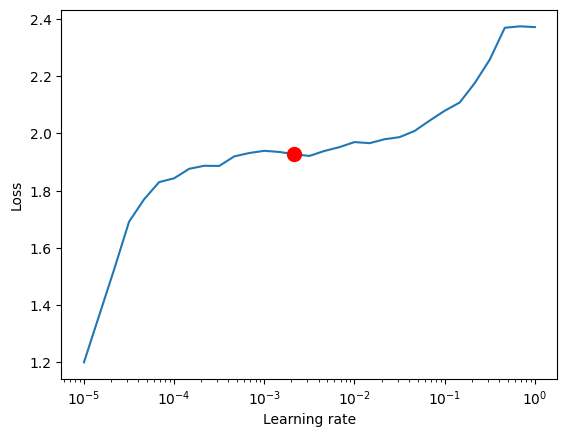

In [16]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['max_epochs']=5
data_module_config['data_module']['batch_size']=64

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)

# Overfit Small Subset

In [17]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size']=128
trainer_config['overfit_batches']=1
lightning_module_config['others']['learning_rate']=0.002
trainer_config['max_epochs']=3
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | TwoLayerMLPBN      | 281 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 |

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.13 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:262: UserWarning: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 52.29, Val_Metric: 0.10 | Train_Loss: 2.43, Train_Metric: 0.09


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 3.26, Val_Metric: 0.11 | Train_Loss: 1.78, Train_Metric: 0.50


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 2.81, Val_Metric: 0.09 | Train_Loss: 1.07, Train_Metric: 1.00


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


# Regularization -I
- Early stopping with a patience of 5, total epochs = 50
- Gradient Clipping
- Weight Deacay of 1
- Reduce Learning rate on plateau
- Use 50% of train/val data

INFO:lightning_fabric.utilities.seed:Global seed set to 42


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs exists and is no

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.31, Val_Metric: 0.09 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 1.83, Val_Metric: 0.36 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.828


Train_Loss: 1.94, Train_Metric: 0.32


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 1.70, Val_Metric: 0.40 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.125 >= min_delta = 0.0. New best score: 1.702


Train_Loss: 1.67, Train_Metric: 0.43


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 1.71, Val_Metric: 0.40 | Train_Loss: 1.48, Train_Metric: 0.50
Epoch 00003: reducing learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 1.64, Val_Metric: 0.45 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 1.643


Train_Loss: 1.19, Train_Metric: 0.62


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 1.84, Val_Metric: 0.41 | Train_Loss: 0.89, Train_Metric: 0.73
Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 1.83, Val_Metric: 0.42 | Train_Loss: 0.58, Train_Metric: 0.85
Epoch 00006: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 1.80, Val_Metric: 0.45 | Train_Loss: 0.35, Train_Metric: 0.93


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 1.94, Val_Metric: 0.42 | Train_Loss: 0.25, Train_Metric: 0.95
Epoch 00008: reducing learning rate of group 0 to 1.2500e-04.


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 1.91, Val_Metric: 0.43 | 

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 1.643. Signaling Trainer to stop.


Train_Loss: 0.18, Train_Metric: 0.98
Epoch 00009: reducing learning rate of group 0 to 6.2500e-05.


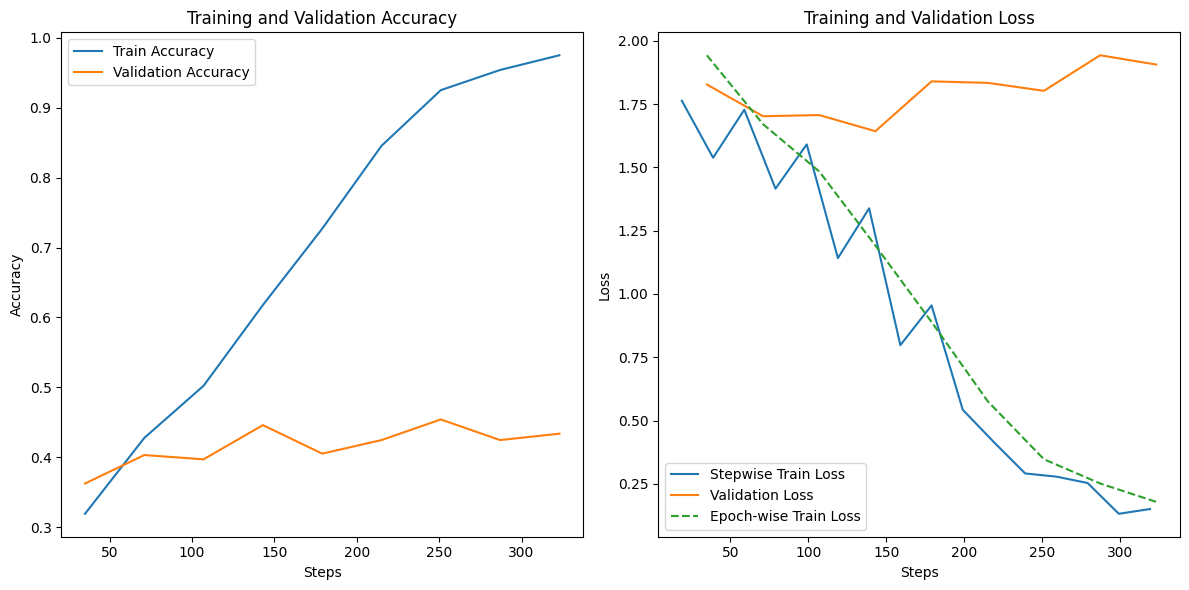

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs/epoch=3-step=144-v2.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs/epoch=3-step=144-v2.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 0.95, Val_Metric: 0.72 | 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs/epoch=3-step=144-v2.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs/epoch=3-step=144-v2.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 1.64, Val_Metric: 0.45 | Train Accuracy: 72.46
Validation Accuracy: 44.60


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
lr-AdamW,███▄▄▂▁▁▁
train_loss_epoch,█▇▆▅▄▃▂▁▁
train_loss_step,█▇█▇▇▅▆▄▅▃▂▂▂▂▁▁
train_metric,▁▂▃▄▅▇▇██
trainer/global_step,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
val_loss,▇▆▆▆▇▇▇██▁▆
val_metric,▁▂▂▃▂▂▃▂▂█▃
epoch,9
lr-AdamW,0.00013
train_loss_epoch,0.17851


In [18]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
# trainer config file
trainer_config['max_epochs']=50
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20

# lightning module config file
lightning_module_config['others']['optimizer_params']['weight_decay']=1
lightning_module_config['others']['learning_rate']=0.002
lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.ReduceLROnPlateau'
lightning_module_config['scheduler_params']= {'mode': 'max', 'patience': 0, 'factor': 0.5, 'verbose': True}
lightning_module_config['scheduler_options']= {'monitor': 'val_metric', 'interval': 'epoch', 'frequency': 1}

# logging config file
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='imagenette2_multiclass_HW'
cl_config['wandb']['name']='two_layer_mlp_bn_r1'

# data module config file
data_module_config['data_module']['batch_size']=128
data_module_config['data_module']['small_subset']=True
data_module_config['data_module']['num_samples_small']=0.5

# load everything
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=True)
dm.setup()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

# Regularization -II
- Increase the weight decay to 10

In [19]:
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='imagenette2_multiclass_HW'
cl_config['wandb']['name']='two_layer_mlp_bn_r2'
lightning_module_config['others']['optimizer_params']['weight_decay']=10

In [20]:
lightning_module_config

{'optimizer_cls': 'torch.optim.AdamW',
 'loss_fn': 'torch.nn.CrossEntropyLoss',
 'metric_cls': 'torchmetrics.Accuracy',
 'scheduler_cls': 'torch.optim.lr_scheduler.ReduceLROnPlateau',
 'scheduler_options': {'monitor': 'val_metric',
  'interval': 'epoch',
  'frequency': 1},
 'scheduler_params': {'mode': 'max',
  'patience': 0,
  'factor': 0.5,
  'verbose': True},
 'others': {'optimizer_params': {'weight_decay': 10},
  'num_classes': 10,
  'learning_rate': 0.002,
  'log_every_n_steps': 1,
  'log_test_metrics': True,
  'display_metrics': True}}

INFO:lightning_fabric.utilities.seed:Global seed set to 42
wandb: Currently logged in as: hsingh-utd. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs exists and is no

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.31, Val_Metric: 0.09 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 1.96, Val_Metric: 0.35 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.961


Train_Loss: 1.96, Train_Metric: 0.32


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 1.97, Val_Metric: 0.37 | Train_Loss: 1.80, Train_Metric: 0.41


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 1.92, Val_Metric: 0.37 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.920


Train_Loss: 1.76, Train_Metric: 0.44
Epoch 00003: reducing learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 1.87, Val_Metric: 0.41 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.874


Train_Loss: 1.66, Train_Metric: 0.51


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 1.88, Val_Metric: 0.38 | Train_Loss: 1.56, Train_Metric: 0.56
Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 1.81, Val_Metric: 0.40 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 1.809


Train_Loss: 1.41, Train_Metric: 0.65
Epoch 00006: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 1.80, Val_Metric: 0.40 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.799


Train_Loss: 1.19, Train_Metric: 0.77
Epoch 00007: reducing learning rate of group 0 to 1.2500e-04.


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 1.79, Val_Metric: 0.42 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.788


Train_Loss: 1.03, Train_Metric: 0.85


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 1.79, Val_Metric: 0.42 | Train_Loss: 0.93, Train_Metric: 0.88


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 1.82, Val_Metric: 0.38 | Train_Loss: 0.84, Train_Metric: 0.91
Epoch 00010: reducing learning rate of group 0 to 6.2500e-05.


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 1.79, Val_Metric: 0.42 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.788


Train_Loss: 0.76, Train_Metric: 0.94
Epoch 00011: reducing learning rate of group 0 to 3.1250e-05.


Validation: 0it [00:00, ?it/s]

Epoch 12: Val_Loss: 1.78, Val_Metric: 0.42 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.784


Train_Loss: 0.71, Train_Metric: 0.96
Epoch 00012: reducing learning rate of group 0 to 1.5625e-05.


Validation: 0it [00:00, ?it/s]

Epoch 13: Val_Loss: 1.79, Val_Metric: 0.41 | Train_Loss: 0.68, Train_Metric: 0.97
Epoch 00013: reducing learning rate of group 0 to 7.8125e-06.


Validation: 0it [00:00, ?it/s]

Epoch 14: Val_Loss: 1.79, Val_Metric: 0.42 | Train_Loss: 0.67, Train_Metric: 0.98
Epoch 00014: reducing learning rate of group 0 to 3.9063e-06.


Validation: 0it [00:00, ?it/s]

Epoch 15: Val_Loss: 1.79, Val_Metric: 0.42 | Train_Loss: 0.67, Train_Metric: 0.97
Epoch 00015: reducing learning rate of group 0 to 1.9531e-06.


Validation: 0it [00:00, ?it/s]

Epoch 16: Val_Loss: 1.80, Val_Metric: 0.42 | Train_Loss: 0.67, Train_Metric: 0.98
Epoch 00016: reducing learning rate of group 0 to 9.7656e-07.


Validation: 0it [00:00, ?it/s]

Epoch 17: Val_Loss: 1.79, Val_Metric: 0.42 | 

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 1.784. Signaling Trainer to stop.


Train_Loss: 0.66, Train_Metric: 0.98
Epoch 00017: reducing learning rate of group 0 to 4.8828e-07.


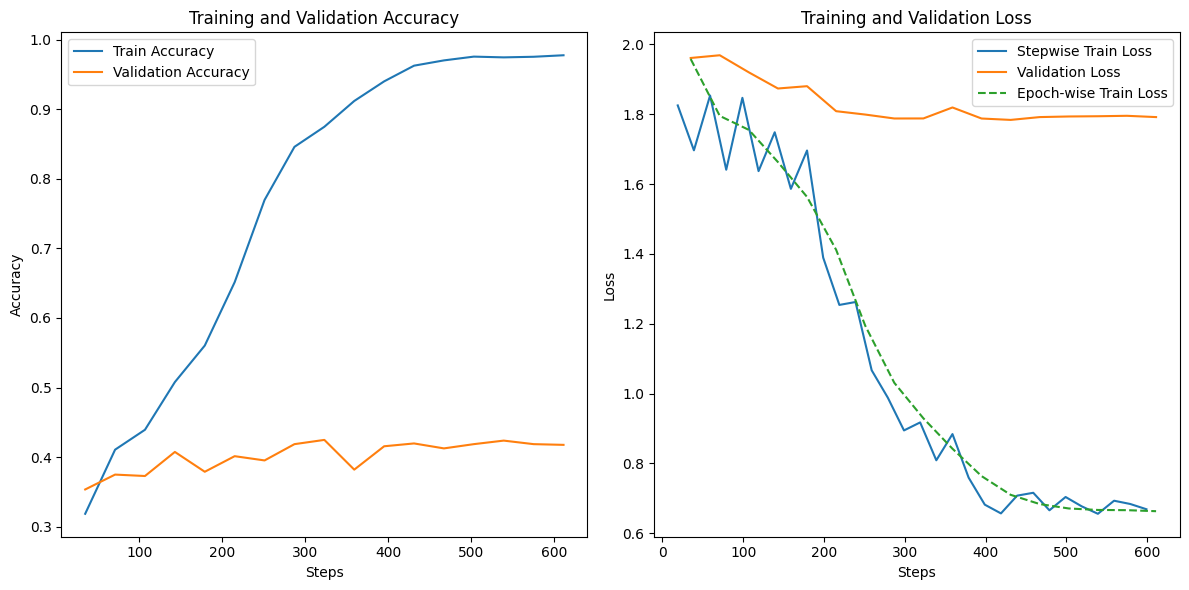

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs/epoch=11-step=432-v2.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs/epoch=11-step=432-v2.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 18: Val_Loss: 0.67, Val_Metric: 0.97 | 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs/epoch=11-step=432-v2.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs/epoch=11-step=432-v2.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 18: Val_Loss: 1.78, Val_Metric: 0.42 | Train Accuracy: 97.27
Validation Accuracy: 41.96


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
lr-AdamW,███▄▄▃▂▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▇▇▆▆▅▄▃▂▂▂▁▁▁▁▁▁
train_loss_step,█▇█▇█▇▇▆▇▅▄▅▃▃▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_metric,▁▂▂▃▄▅▆▇▇▇███████
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
val_loss,███▇█▇▇▇▇▇▇▇▇▇▇▇▇▁▇
val_metric,▁▁▁▂▁▂▁▂▂▁▂▂▂▂▂▂▂█▂
epoch,17
lr-AdamW,0.0
train_loss_epoch,0.66296


In [21]:
# Regularization -II
free_memory()
seed_everything(42)

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=True)
dm.setup()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

# Regularization -III
- Use one Cycle Learning Rate instead of Reduce Learning Rate on Plateau

In [22]:
free_memory()
seed_everything(42)

model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# trainer_config
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20
trainer_config['max_epochs']=10

# lightning module config
lightning_module_config['others']['learning_rate']=0.002
lightning_module_config['others']['optimizer_params']['weight_decay']=1

# Setting the scheduler class
lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.OneCycleLR'

# Parameters for the OneCycleLR
# Note: 'max_lr' is a required parameter for OneCycleLR; you'll need to specify it based on your needs
lightning_module_config['scheduler_params'] = {
    'max_lr': 0.01,  # Example value, adjust as necessary
    'epochs': 10,  # Optional: Total number of epochs.
    'steps_per_epoch': 75,  # Optional: Number of steps per epoch.
    'pct_start': 0.3,  # Percentage of the cycle (in number of steps) spent increasing the learning rate.
    'anneal_strategy': 'cos',  # {'cos', 'linear'}
    'cycle_momentum': True,
    'base_momentum': 0.85,
    'max_momentum': 0.95,
    'div_factor': 25.0,
    'final_div_factor': 1e4,
    'last_epoch': -1,
    'verbose': False
}

# Options related to the monitoring of the scheduler (if needed)
lightning_module_config['scheduler_options'] = {
    'monitor': 'val_metric',  # Adjust based on your validation metric's name
    'interval': 'step',  # The interval (either 'step' or 'epoch') at which the scheduler updates its learning rate.
    'frequency': 1  # The frequency of the scheduler updates in terms of the chosen interval.
}

# logging config
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='imagenette2_multiclass_HW'
cl_config['wandb']['name']='two_layer_mlp_bn_r3'

# data module
data_module_config['data_module']['batch_size']=128
data_module_config['data_module']['small_subset']=True
data_module_config['data_module']['num_samples_small']=0.5

# loadd all componments
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=False) # change here
dm.setup()

INFO:lightning_fabric.utilities.seed:Global seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | TwoLayerMLPBN      | 281 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
281 M     Trainable params
0         Non-trainable params
281 M     Total params
1,126.032 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.31, Val_Metric: 0.09 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 1.78, Val_Metric: 0.39 | Train_Loss: 1.89, Train_Metric: 0.35


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 1.75, Val_Metric: 0.40 | Train_Loss: 1.61, Train_Metric: 0.46


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 1.90, Val_Metric: 0.35 | Train_Loss: 1.49, Train_Metric: 0.49


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 1.89, Val_Metric: 0.37 | Train_Loss: 1.41, Train_Metric: 0.53


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 1.83, Val_Metric: 0.37 | Train_Loss: 1.33, Train_Metric: 0.56


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 1.80, Val_Metric: 0.37 | Train_Loss: 1.28, Train_Metric: 0.58


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 1.90, Val_Metric: 0.36 | Train_Loss: 1.23, Train_Metric: 0.59


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 1.84, Val_Metric: 0.38 | Train_Loss: 1.20, Train_Metric: 0.61


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 1.83, Val_Metric: 0.38 | Train_Loss: 1.16, Train_Metric: 0.62


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 1.89, Val_Metric: 0.36 | Train_Loss: 1.13, Train_Metric: 0.64


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


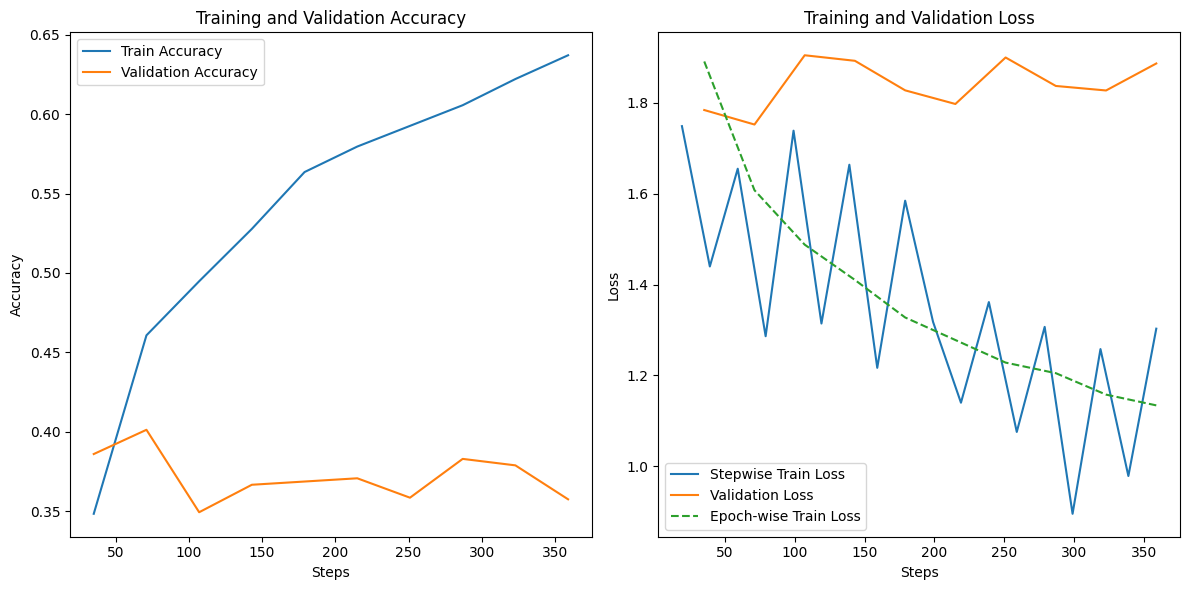

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs/epoch=1-step=72.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs/epoch=1-step=72.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 1.45, Val_Metric: 0.51 | 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs/epoch=1-step=72.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs/epoch=1-step=72.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 1.75, Val_Metric: 0.40 | Train Accuracy: 51.02
Validation Accuracy: 40.12


epoch,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
lr-AdamW,▁▁▃▄▆▇███▇
train_loss_epoch,█▅▄▄▃▂▂▂▁▁
train_loss_step,█▅▇▄█▄▇▄▇▄▃▅▂▄▁▄▂▄
train_metric,▁▄▅▅▆▇▇▇██
trainer/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
val_loss,▆▆██▇▆█▇▇█▁▆
val_metric,▃▃▁▂▂▂▁▂▂▁█▃
epoch,10
lr-AdamW,0.00913
train_loss_epoch,1.134


In [23]:
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

# Regularization-1V
- Use one Step LR instead of One Cycler LR

INFO:lightning_fabric.utilities.seed:Global seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs exists and is no

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.13 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 1.73, Val_Metric: 0.41 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.728


Train_Loss: 1.86, Train_Metric: 0.35


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 1.62, Val_Metric: 0.44 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.103 >= min_delta = 0.0. New best score: 1.625


Train_Loss: 1.56, Train_Metric: 0.47


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 1.61, Val_Metric: 0.46 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.614


Train_Loss: 1.33, Train_Metric: 0.56


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 1.62, Val_Metric: 0.47 | Train_Loss: 1.04, Train_Metric: 0.68


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 1.66, Val_Metric: 0.47 | Train_Loss: 0.77, Train_Metric: 0.78


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 1.67, Val_Metric: 0.47 | Train_Loss: 0.59, Train_Metric: 0.85


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 1.69, Val_Metric: 0.47 | Train_Loss: 0.49, Train_Metric: 0.89


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 1.70, Val_Metric: 0.46 | 

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 1.614. Signaling Trainer to stop.


Train_Loss: 0.44, Train_Metric: 0.90


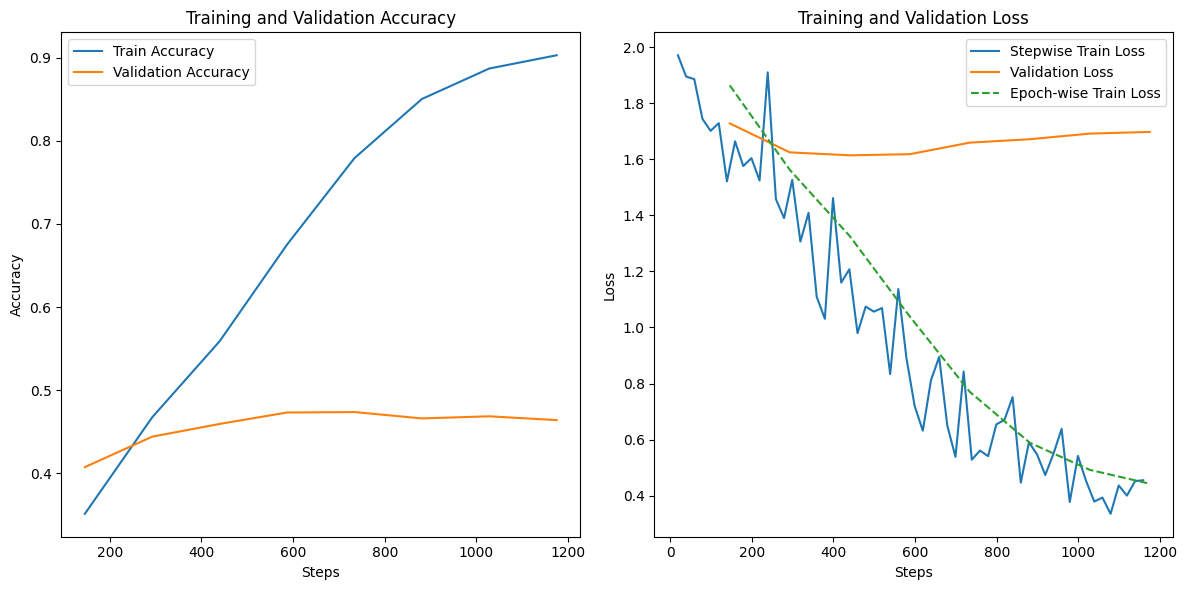

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs/epoch=2-step=441.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs/epoch=2-step=441.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 1.10, Val_Metric: 0.66 | 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs/epoch=2-step=441.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/imagenette2/logs/epoch=2-step=441.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 1.61, Val_Metric: 0.46 | Train Accuracy: 65.77
Validation Accuracy: 45.95


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█
lr-AdamW,█████▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▇▅▄▃▂▁▁
train_loss_step,███▇▇▇▆▆█▅▆▆▄▆▄▅▄▄▃▄▃▂▃▂▃▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁
train_metric,▁▂▄▅▆▇██
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▇▇▇▇▇██▁▇
val_metric,▁▂▂▃▃▃▃▃█▂
epoch,8
lr-AdamW,2e-05
train_loss_epoch,0.4425


In [24]:
free_memory()
seed_everything(42)

model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20
trainer_config['max_epochs']=50

# lightning module config file
lightning_module_config['others']['learning_rate']=0.002
lightning_module_config['others']['optimizer_params']['weight_decay']=1

lightning_module_config['scheduler_cls']= 'torch.optim.lr_scheduler.StepLR'
lightning_module_config['scheduler_params']= {'step_size':1, 'gamma':0.5}
lightning_module_config['scheduler_options']= {
    'monitor': 'val_metric',  # Adjust based on your validation metric's name
    'interval': 'epoch',  # The interval (either 'step' or 'epoch') at which the scheduler updates its learning rate.
    'frequency': 1  # The frequency of the scheduler updates in terms of the chosen interval.
}

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=True)

# logging config
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='imagenette2_multiclass_HW'
cl_config['wandb']['name']='two_layer_mlp_bn_r4'

# data module
data_module_config['data_module']['batch_size']=128
data_module_config['data_module']['small_subset']=True
data_module_config['data_module']['num_samples_small']=0.5


trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()